# This notebook processes transect data from 30th August

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import xarray
import pickle
import cartopy.feature as cfeature
from scipy.stats import pearsonr
import math
import cartopy.crs as ccrs
import scipy
import cartopy
import datetime
from scipy.stats import binned_statistic
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
import kuka_tools as kt

In [2]:
directory = '/home/robbie/Dropbox/kuka_bare/data/rothera/netcdfs/20230830'

In [3]:
listfiles = os.listdir(directory)
listfiles

ku_files = sorted([f for f in listfiles if 'Ku-Scat' in f])[-2:]
ka_files = sorted([f for f in listfiles if 'Ka-Scat' in f])[-2:]

(-1.0, 35.0)

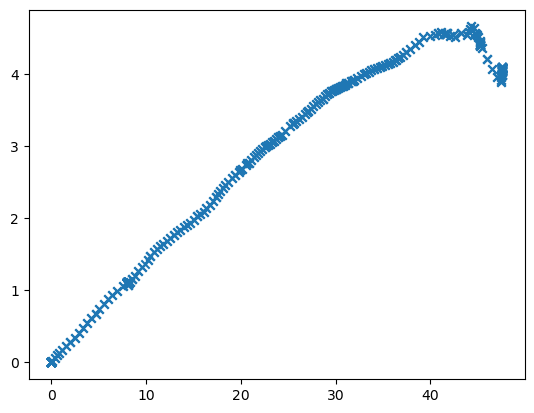

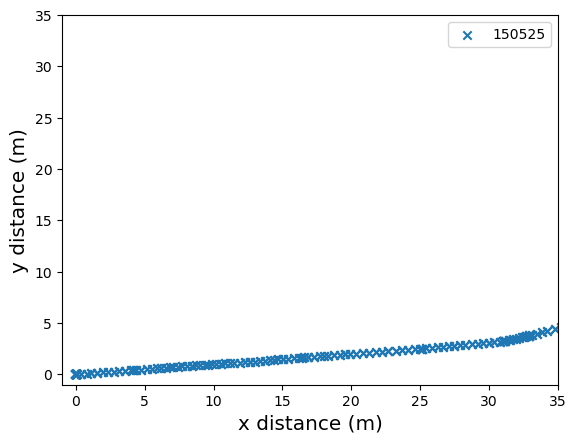

In [4]:
x,y=kt.plot_pos(ku_files[0],directory,plot=False)

x0 = -2300414.994491106; y0 = 923485.871699531
xy_dict = {}

for f in ku_files:

    x,y = kt.plot_pos(f,directory,x0=x0,y0=y0)

    xy_dict[f] = (x,y)

# plt.scatter(x0,y0)
plt.legend()
plt.xlabel('x distance (m)',fontsize='x-large')
plt.ylabel('y distance (m)',fontsize='x-large')

plt.xlim(-1,35)
plt.ylim(-1,35)

609
51


(250.0, 300.0)

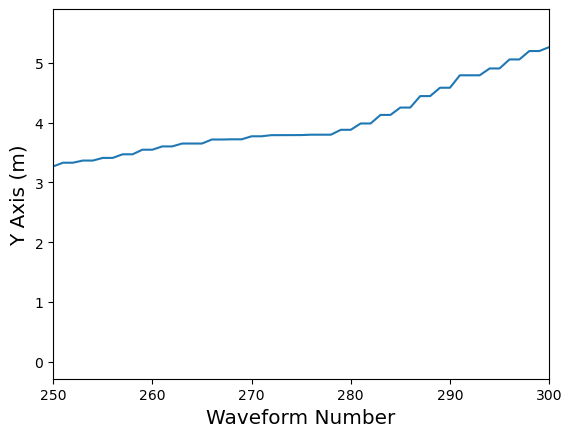

In [5]:
for f in ku_files[0:2]:
    x,y = xy_dict[f]
    print(np.argmin(x))
    times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in Dataset(f'{directory}/{f}')['start_time']])
plt.plot(y)
plt.ylabel('Y Axis (m)',fontsize='x-large')
plt.xlabel('Waveform Number',fontsize='x-large')

plt.xlim(250,300)

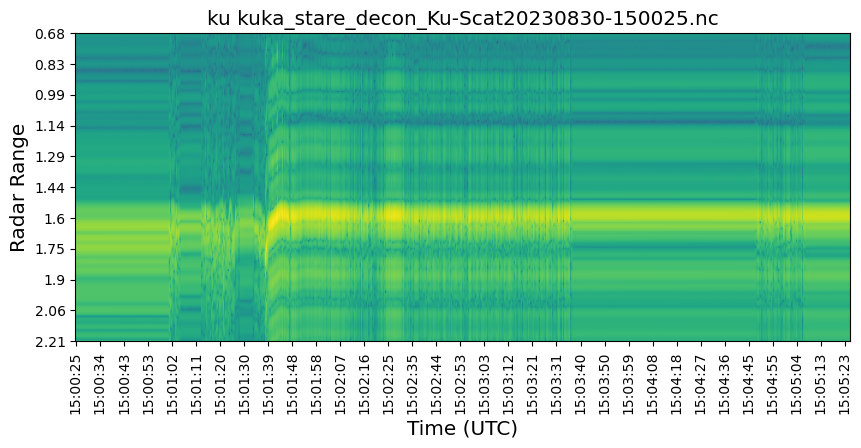

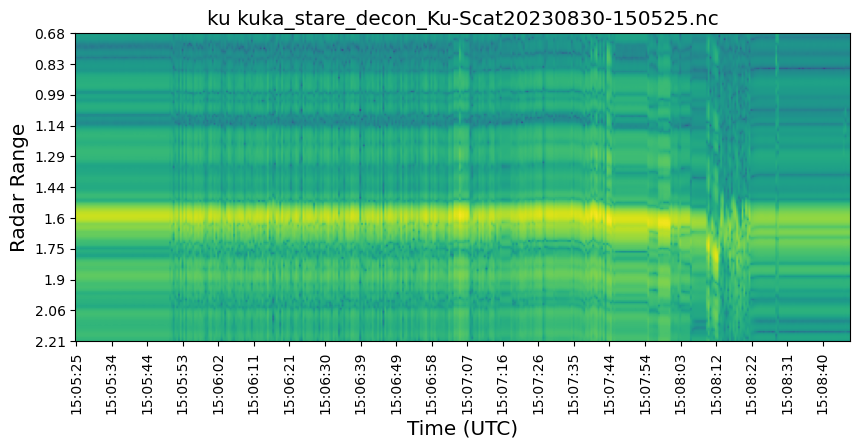

In [6]:
for f in ku_files[0:2]:
    kt.plot_file(f,'ku',directory,)
    plt.xlabel('Time (UTC)',fontsize='x-large')
    plt.ylabel('Radar Range',fontsize='x-large')

In [7]:
# minrange = 1.3
# maxrange = 2
# gate0,gate1 = kt.get_range_index(minrange,np.array(d['range'])),kt.get_range_index(maxrange,np.array(d['range']))

# bw = 0.5
# bins=np.arange(0,26.1,bw)

# mean_powers = []

# for i in bins:
    
#     mask = np.where((along_track<i+bw)&(along_track>i))[0]
#     start_ind=mask[0];end_ind=mask[-1]
#     # print(start_ind,end_ind)
    
#     mean_powers.append( np.mean(np.array(d['vv_power_decon0'])[gate0:gate1,start_ind:end_ind],axis=1) )
    
# plt.plot(np.nanmean(mean_powers,axis=0)    )

#     # plt.show()
#     # break
# # mask

In [30]:
foi = ku_files[0]
d = Dataset(f'{directory}/{foi}')
x,y = xy_dict[foi]

range = np.array(d['range'])

times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

mintime=0
maxtime=-1

x_ = 0; y_ = 0

along_track = np.sqrt((x-x_)**2 + (y-y_)**2)

xdiff = np.diff(x)
ydiff = np.diff(y)
speed = np.sqrt(np.square(xdiff)+np.square(ydiff))
speed=list(speed)+[0]
# df = df[df['speed']>0.1]


nrcs = pd.DataFrame(kt.get_nrcs(d,'ku'))
nrcs['corr']=kt.calc_corrs(d,1,4)
nrcs['along_track']=along_track
nrcs['speed']=speed

nrcs_return = nrcs.iloc[mintime:maxtime]

nrcs_return = nrcs_return.sort_values('along_track').reset_index(drop=True)

nrcs_return = nrcs_return[nrcs_return['along_track']<30]

nrcs_return = nrcs_return[nrcs_return['corr']<0.999]

nrcs_return

,vv,hv,vh,hh,corr,along_track,speed
35,2.208989,0.002579,0.004151,2.572151,0.998576,0.051591,0.062315
36,1.675403,0.003087,0.002251,1.780487,0.989197,0.051591,0.000000
37,2.234748,0.004137,0.002899,3.091532,0.992335,0.390277,0.338822
38,0.112846,0.005357,0.007458,0.113718,0.511444,0.390277,0.000000
39,1.509104,0.006009,0.002409,1.725517,0.657909,0.664534,0.274375
...,...,...,...,...,...,...,...
394,0.062788,0.003011,0.003493,0.039878,0.665860,29.542943,0.000000
395,0.131965,0.006591,0.008463,0.187954,0.880504,29.796802,0.253963
396,0.165134,0.010708,0.009644,0.246276,0.870013,29.796802,0.000000
397,1.315192,0.026577,0.023800,1.365709,0.864347,29.896004,0.099229


In [31]:
power_threshold = np.max(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold_arg = np.argmax(nrcs_return['vv'][nrcs_return['along_track']<25])
power_threshold,power_threshold_arg

(4.36269964181854, 53)

In [37]:
start_ind = np.argmax(nrcs_return['vv']>power_threshold)
start_along_track = nrcs_return['along_track'].iloc[start_ind]

nrcs_reverse = nrcs_return.reindex(index=nrcs_return.index[::-1])
end_ind = np.argmax(nrcs_reverse['vv']>power_threshold)
end_along_track = nrcs_reverse['along_track'].iloc[end_ind]
start_along_track,end_along_track

(26.98249594647257, 28.62470650564627)

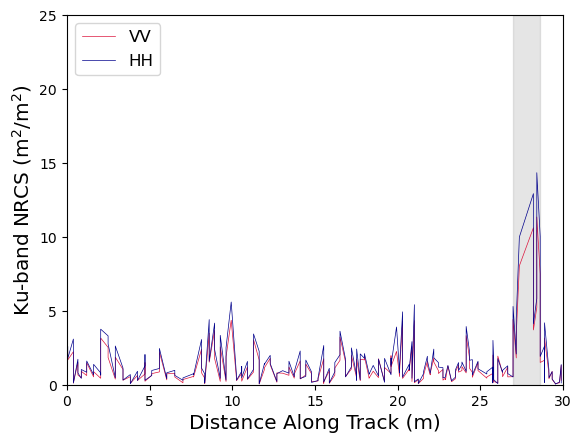

In [38]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['vv'],
         label='VV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['hh'],
         label='HH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ku-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')



plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
plt.ylim(0,25)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [39]:
ff_pickles = '/home/robbie/Dropbox/kuka_bare/data/pickles/FF_fig'
pickle.dump((nrcs_return,
             start_along_track,
             end_along_track),
            open(f'{ff_pickles}/ku30.p','wb'))

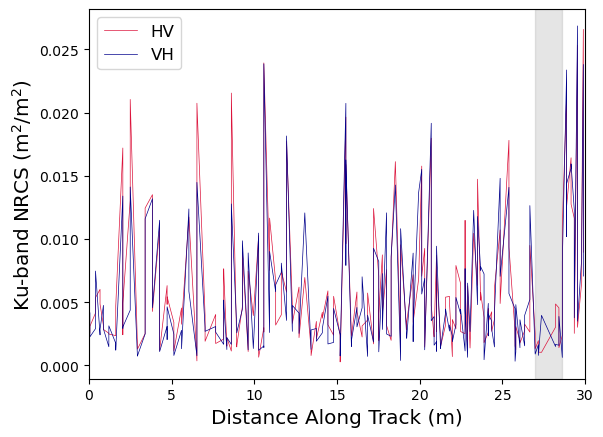

In [34]:
plt.plot(nrcs_return['along_track'],
         nrcs_return['hv'],
         label='HV',
         lw=0.5,
         color='crimson')

plt.plot(nrcs_return['along_track'],
         nrcs_return['vh'],
         label='VH',
         lw=0.5,
         color='darkblue')

plt.ylabel('Ku-band NRCS (m$^2$/m$^2$)',fontsize='x-large')
plt.xlabel('Distance Along Track (m)',fontsize='x-large')

plt.axvspan(start_along_track,end_along_track,color='grey',alpha=0.2)
# plt.ylim(0,40)
plt.xlim(0,30)
plt.legend(fontsize='large')
plt.show()

In [35]:
pickle.dump(nrcs_return,open('../../data/pickles/NRCS_830_KU.p','wb'))
start_along_track,end_along_track

(26.98249594647257, 28.62470650564627)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f39fd2e1e10>]}

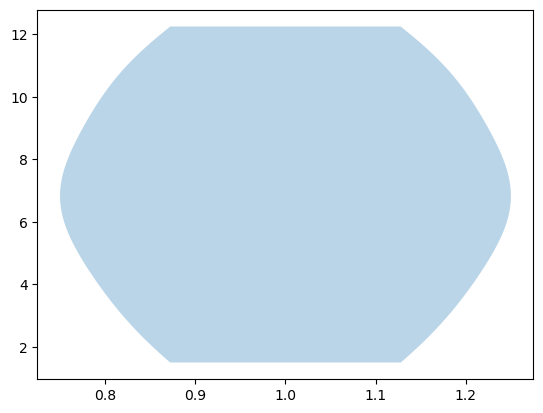

In [36]:
minind,maxind=np.argmin(np.abs(along_track-start_along_track)),np.argmin(np.abs(along_track-end_along_track))
minind,maxind

plt.violinplot(nrcs['vv'][maxind:minind],showextrema=False)